# Maximum Likelihood Estimation

## Probability distribution case

In [1]:
import numpy as np
import matplotlib.pyplot as plt

(1000,)


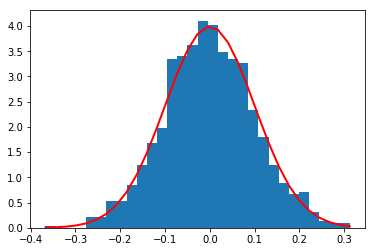

In [2]:
mu, sigma = 0, 0.1 # true mean and standard deviation
data = np.random.normal(mu, sigma, 1000)
print(data.shape)

count, bins, ignored = plt.hist(data, 30, density=True)
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r')
plt.show()

In [3]:
from UQpy.Inference import Model
candidate_model = Model(model_type = 'pdf', model_name='normal')

In [4]:
from UQpy.Inference import MLEstimation
ml_estimator = MLEstimation(model_instance=candidate_model, data=data)
print('ML estimates of the mean={0:.3f} and std. dev={1:.3f}'.format(ml_estimator.param[0], ml_estimator.param[1]))

Evaluating max likelihood estimate...
ML estimates of the mean=-0.002 and std. dev=0.101


## Regression model (model linear in the parameters)

In [5]:
# Generate data
from scipy.stats import multivariate_normal

param_true = np.array([1.0, 2.0]).reshape(1, -1)
error_covariance = np.eye(50)

print(param_true.shape)
from UQpy.RunModel import RunModel
z = RunModel(samples=param_true, model_type='python', model_script='pfn_quadratic.py')

data = z.model_eval.QOI[0]+multivariate_normal.rvs(mean=None, cov=error_covariance, size=1)
print(data)

(1, 2)

Evaluating the model...

[ 8.15656690e-02  1.80165126e+00 -4.62531798e-01  4.24384549e-01
  3.29335437e+00  3.48284154e+00  4.94692494e+00  4.67937315e+00
  6.36785152e+00  9.12073342e+00  9.07089258e+00  1.38129851e+01
  1.54277401e+01  1.68458723e+01  2.11635998e+01  2.19220266e+01
  2.35731440e+01  2.67445133e+01  2.88612144e+01  3.40770039e+01
  3.70088988e+01  4.05771537e+01  4.58117590e+01  4.80057934e+01
  5.28085169e+01  5.76351754e+01  6.08613913e+01  6.47730733e+01
  7.16937589e+01  7.61577916e+01  8.19929157e+01  8.69264409e+01
  9.02459997e+01  9.65151676e+01  1.04009391e+02  1.07076291e+02
  1.15263755e+02  1.22362052e+02  1.28337641e+02  1.34282663e+02
  1.39449997e+02  1.50458129e+02  1.55681164e+02  1.64141145e+02
  1.71621521e+02  1.77910324e+02  1.84161542e+02  1.93729280e+02
  2.02155348e+02  2.11334931e+02]


In [6]:
candidate_model = Model(model_type='python', model_script='pfn_quadratic.py', n_params=2, 
                        error_covariance=error_covariance)

In [7]:
ml_estimator = MLEstimation(model_instance=candidate_model, data=data)

Evaluating max likelihood estimate...
Optimization terminated successfully.
         Current function value: 72.142498
         Iterations: 66
         Function evaluations: 127


In [8]:
print(ml_estimator.param)

[0.9053673  2.01324768]
